In [2]:
import pandas as pd

from jax import random, jit
from jax import numpy as jnp
from jax.numpy.fft import fft, ifft
import glob
from matplotlib import pyplot as plt
from jaxopt import BFGS
jnp_float = jnp.float32
from time import time

from contextlib import contextmanager
import os
import sys

from scipy.stats import shapiro


# function to allow print suppression
@contextmanager
def suppress_print():
    # Save the current stdout
    original_stdout = sys.stdout
    # Redirect stdout to null
    sys.stdout = open(os.devnull, 'w')
    try:
        yield
    finally:
        # Restore the original stdout
        sys.stdout.close()
        sys.stdout = original_stdout

@jit
def exponential(t, A1, tau1):
    return A1 * jnp.exp(-t / tau1)

def multi_exponential(t, *params):
    x, offset = params[:-1], params[-1]
    n = len(x) // 2
    return jnp.sum(jnp.array([exponential(t, x[2*i], x[2*i+1]) for i in range(n)], dtype=jnp_float), axis=0) - offset

@jit
def fit_multi_exponential(t, *params):
    
    x = params
    
    n = len(x) // 2
    
    decay = jnp.sum(jnp.array([exponential(t, x[2*i], x[2*i+1]) for i in range(n)], dtype=jnp_float), axis=0)
    
    last_mean_offset = jnp.mean(decay[-1000:-10]) if use_adjustment else 0
    
    return decay - last_mean_offset

# printout the parameters
def print_params(params):
    x = params
    for i in range(0, len(x), 2):
        print(f"decay {i//2 + 1}: {x[i]:.4f} {x[i+1]:.2f}")

def durbin_watson(residuals): 
    """
    This is a modified version of the Durbin-Watson statistic that is 
    used to test for autocorrelation in the residuals.
    
    The output has been modified to go from 0 to 1 instead of 0 to 4.
    0 indicates no correlation and 1 indicates correlation.
    
    It is therefore a correlation coefficient.
    """
    diff = jnp.diff(residuals) 
    dw_stat = jnp.sum(diff ** 2) / jnp.sum(residuals ** 2) 
    return jnp.abs(dw_stat-2)/2.0

def shapiro_wilk(residuals):
    """
    This is the Shapiro-Wilk test for normality.
    
    The output is the test statistic and the p-value.
    The statistic has a range of 0 to 1, but will mostly be between 0.9 and 1.
    1 indicates normality, but the p-value is the most important output.
    The p-value represents the probability that the data is normally distributed.
    A common threshold for normality is 0.05, above which the data is considered normal.
    """
    return shapiro(residuals)

# produces a solver function to optimize
def get_solve(maxiter, atol, time_data, noisy_signal, magnitudes):
    
    forward = jit(lambda x: x / magnitudes)
    backward = jit(lambda x: x * magnitudes)
    
    @jit
    def loss_fn(params):
        params = backward(params)
        return jnp.sum((fit_multi_exponential(time_data, *params) - noisy_signal) ** 2)
        
    # Define the solver
    solver = BFGS(
        fun=loss_fn,
        maxiter=2000,
        tol=1e-20,
        max_stepsize=0.5,
        min_stepsize=1e-20,
    )
    
    @jit
    def init_state(params):
        return solver.init_state(params)
    
    @jit
    def update(params, state):
        return solver.update(params, state)
    
    @jit 
    def is_close(x, y):
        return jnp.isclose(x, y, atol=atol)
    
    def solve(params):
        params = forward(params)
        state = init_state(params)
        
        last = -1
        same_last_count = 0
        with suppress_print():
            for _ in range(maxiter):
                params, state = update(params, state)
                if is_close(state.value, last):
                    same_last_count += 1
                else:
                    same_last_count = 0
                if same_last_count > 10:
                    break
                last = state.value
        
        return backward(params), state
    
    return solve

def get_bootstrap_solve(atol, time_data, noisy_signal, params):
    
    # defines functions to dedimensionalize and normalize the parameters
    # for a smoother optimization
    # forward is not needed here as params ≡ magnitudes
    backward = jit(lambda x: x * params)
    
    params_i = jnp.ones_like(params)
    n = len(noisy_signal)
    
    @jit
    def is_close(x, y):
        return jnp.isclose(x, y, atol=atol)
    
    @jit
    def initialize_bootstrap(key):
        # sample bootstrap data indices from the noisy signal
        bootstrap_indices = random.choice(key, n, (n,), replace=True)
        noisy_signal_bootstrap = noisy_signal[bootstrap_indices]
        time_data_bootstrap = time_data[bootstrap_indices]
        
        def loss_fn(params):
            # transform the params to the correct scale
            params = backward(params)
            return jnp.sum((fit_multi_exponential(time_data_bootstrap, *params) - noisy_signal_bootstrap) ** 2)
        
        solver = BFGS(
            fun=loss_fn,
            maxiter=2000,
            tol=1e-20,
            max_stepsize=0.1,
            min_stepsize=1e-20,
        )
        
        state = solver.init_state(params_i)
        
        return state, noisy_signal_bootstrap, time_data_bootstrap
    
    @jit
    def solve_10(params, state, noisy_signal_bootstrap, time_data_bootstrap):
        
        def loss_fn(params):
            # transform the params to the correct scale
            params = backward(params)
            return jnp.sum((fit_multi_exponential(time_data_bootstrap, *params) - noisy_signal_bootstrap) ** 2)
        
        solver = BFGS(
            fun=loss_fn,
            maxiter=2000,
            tol=1e-20,
            max_stepsize=0.1,
            min_stepsize=1e-20,
        )
        
        for _ in range(10):
            params, state = solver.update(params, state)
        
        return params, state

    def solve(key):
        state, noisy_signal_bootstrap, time_data_bootstrap = initialize_bootstrap(key)
        params = params_i
        done = False
        last = -1
        before_last = -1
        with suppress_print():
            while not done:
                params, state = solve_10(params, state, noisy_signal_bootstrap, time_data_bootstrap)
                done = is_close(state.value, last) and is_close(before_last, last)
                before_last = last
                last = state.value
        return backward(params), state
    
    return solve


In [ ]:
# use_adjustment indicates whether the parameter-less loss adjustment should be used
use_adjustment = False

# pre or post, with regard to patient data before and after dialysis
post = 0
prepost = "Post" if post else "Pre"


# index of the patient number for file referencing
index = 26

# copy_dict is populated throughout the program to store information to be copied to excel
copy_dict = {}

# TODO: 
# - ensure that all decays are sorted by tau
# - something might have to be done about eliminating values from relative amplitude calculations and 
# what happens when a decay constant strays above 20!

# DONE: 
# - make sure that the tri-exponential optimizations have access to early tau0 values


c:\Users\omnic\OneDrive\Desktop\HC MGRH preprocesssed\B_avgScans_HC12MGHRA-.csv
Loaded file: c:\Users\omnic\OneDrive\Desktop\HC MGRH preprocesssed\B_avgScans_HC12MGHRA-.csv
Index(['%TIME(s)', '%AMP(uV)'], dtype='object')
signal length: 2725


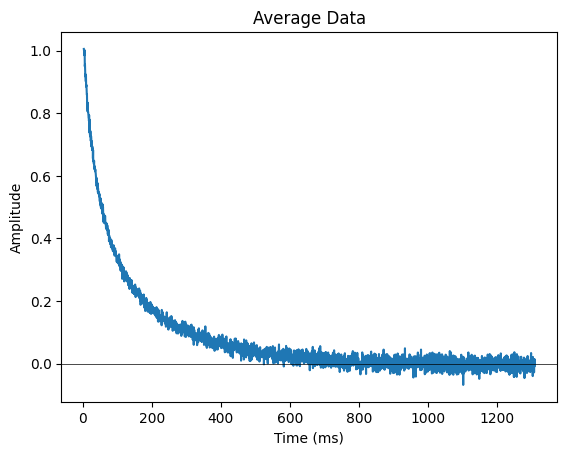

In [101]:

#####################################
#### IMPORT SIGNAL DATA FROM CSV ####
#####################################

def get_filename_from_index(index, prepost):
    # Define the file paths
    files = [
        r"c:\Users\omnic\OneDrive\Desktop\HC MGRH preprocesssed\Post\B_avgScans_HD05MGHI-Post.csv", # 0
        r"c:\Users\omnic\OneDrive\Desktop\HC MGRH preprocesssed\Post\B_avgScans_HD08MGHI-Post.csv", # 1
        r"c:\Users\omnic\OneDrive\Desktop\HC MGRH preprocesssed\Post\B_avgScans_HD06FKCC-Post.csv", # 2
        r"c:\Users\omnic\OneDrive\Desktop\HC MGRH preprocesssed\Post\B_avgScans_HD07FKCC-Post.csv", # 3
        r"c:\Users\omnic\OneDrive\Desktop\HC MGRH preprocesssed\Post\B_avgScans_HD08FKCC-Post.csv", # 4
        r"c:\Users\omnic\OneDrive\Desktop\HC MGRH preprocesssed\Post\B_avgScans_HD09FKCC-Post.csv", # 5
        r"c:\Users\omnic\OneDrive\Desktop\HC MGRH preprocesssed\Post\B_avgScans_HD03FKCC2-Post.csv", # 6
        r"c:\Users\omnic\OneDrive\Desktop\HC MGRH preprocesssed\Post\B_avgScans_HD04FKCC2-Post.csv", # 7
        r"c:\Users\omnic\OneDrive\Desktop\HC MGRH preprocesssed\Post\B_avgScans_HD07FKCC2-Post.csv", # 8
        r"c:\Users\omnic\OneDrive\Desktop\HC MGRH preprocesssed\Post\B_avgScans_HD08FKCC2-Post.csv", # 9
        r"c:\Users\omnic\OneDrive\Desktop\HC MGRH preprocesssed\Post\B_avgScans_HD02FKCS-Post.csv", # 10
        r"c:\Users\omnic\OneDrive\Desktop\HC MGRH preprocesssed\Post\B_avgScans_HD03FKCS-Post.csv", # 11
        r"c:\Users\omnic\OneDrive\Desktop\HC MGRH preprocesssed\Post\B_avgScans_HD04FKCS-Post.csv", # 12
        r"c:\Users\omnic\OneDrive\Desktop\HC MGRH preprocesssed\Post\B_avgScans_HD05FKCS-Post.csv", # 13
        r"c:\Users\omnic\OneDrive\Desktop\HC MGRH preprocesssed\Post\B_avgScans_HD06FKCS-Post.csv", # 14
        r"c:\Users\omnic\OneDrive\Desktop\HC MGRH preprocesssed\B_avgScans_HC01MGHRA-.csv", # 15
        r"c:\Users\omnic\OneDrive\Desktop\HC MGRH preprocesssed\B_avgScans_HC02MGHRA-.csv", # 16
        r"c:\Users\omnic\OneDrive\Desktop\HC MGRH preprocesssed\B_avgScans_HC03MGHRA-.csv", # 17
        r"c:\Users\omnic\OneDrive\Desktop\HC MGRH preprocesssed\B_avgScans_HC04MGHRA-.csv", # 18
        r"c:\Users\omnic\OneDrive\Desktop\HC MGRH preprocesssed\B_avgScans_HC05MGHRA-.csv", # 19
        r"c:\Users\omnic\OneDrive\Desktop\HC MGRH preprocesssed\B_avgScans_HC06MGHRA-.csv", # 20
        r"c:\Users\omnic\OneDrive\Desktop\HC MGRH preprocesssed\B_avgScans_HC07MGHRA-.csv", # 21
        r"c:\Users\omnic\OneDrive\Desktop\HC MGRH preprocesssed\B_avgScans_HC08MGHRA-.csv", # 22
        r"c:\Users\omnic\OneDrive\Desktop\HC MGRH preprocesssed\B_avgScans_HC09MGHRA-.csv", # 23
        r"c:\Users\omnic\OneDrive\Desktop\HC MGRH preprocesssed\B_avgScans_HC10MGHRA-.csv", # 24
        r"c:\Users\omnic\OneDrive\Desktop\HC MGRH preprocesssed\B_avgScans_HC11MGHRA-.csv", # 25
        r"c:\Users\omnic\OneDrive\Desktop\HC MGRH preprocesssed\B_avgScans_HC12MGHRA-.csv", # 26
        r"c:\Users\omnic\OneDrive\Desktop\HC MGRH preprocesssed\B_avgScans_HC13MGHRA-.csv", # 27
        r"c:\Users\omnic\OneDrive\Desktop\HC MGRH preprocesssed\B_avgScans_HC14MGHRA-.csv", # 28
        
    ]
    
    # Check the index is valid
    assert type(index) == int, "index must be an integer"
    assert index < len(files), "index must be less than the total number of files: " + str(len(files))
    assert index >= 0, "index must be greater than or equal to 0"
    assert prepost.lower() in ["pre", "post"], "prepost must be either 'pre' or 'post'"
    
    # Get the filename and replace the prepost if necessary
    filename = files[index]
    if prepost.lower() == "pre":
        filename = filename.replace("Post", "Pre")
    
    return filename


# Define the file path pattern
# file_path_pattern = r"C:\Users\omnic\OneDrive\Desktop\HC MGRH preprocesssed\B_avgScans_HC*MGHRA-.csv"
# file_path_pattern = r"C:\Users\omnic\OneDrive\Desktop\HC MGRH preprocesssed\B_avgScans_HC0[1-8]MGHRA-.csv"
# file_path_pattern = r"C:\Users\omnic\OneDrive\Desktop\HC MGRH preprocesssed\B_avgScans_HC01MGHRA-.csv"
# file_path_pattern = r"C:\Users\omnic\OneDrive\Desktop\HC MGRH preprocesssed\pre_post\B_avgScans_HD07FKCC-Post.csv"

file_path_pattern = get_filename_from_index(index, prepost)
print(file_path_pattern)

# Use glob to find all matching file paths
file_paths = glob.glob(file_path_pattern)

# List to store dataframes
dataframes = []

# Load and process each file
for file_path in file_paths:
    # Read the file, skipping the first 40 rows
    df = pd.read_csv(file_path, skiprows=39)
    dataframes.append(df)
    print(f"Loaded file: {file_path}")

# Ensure all DataFrames have the same structure
if not all(df.columns.equals(dataframes[0].columns) for df in dataframes):
    raise ValueError("Files do not have matching columns.")

# print out the columns
for df in dataframes:
    print(dataframes[0].columns)
    # apparently there's a value in df.values that has a non-numeric value
    # let's find it
    for i, row in enumerate(df.values):
        for j, value in enumerate(row):
            try:
                float(value)
            except:
                print(f"Non-numeric value at row {i} column {j}: {value}")
    # data = jnp.array(df.values)

print(f"signal length: {len(dataframes[0])}")

# Stack all DataFrames to calculate the mean
stacked_data = jnp.stack([jnp.array(df.values) for df in dataframes])

# the shape of this is (12, 2725, 2)
# this is (signal-number, time_point, [time,amplitude])

# normalize the data in each row via the average of their first three values
normalization_factor = jnp.mean(stacked_data[:, :3, 1], axis=1)[:, None]
stacked_data = stacked_data.at[:, :, 1].set(stacked_data[:, :, 1]/normalization_factor)

# Calculate the average across the files
average_data = jnp.mean(stacked_data, axis=0)
time_data = average_data[:, 0]*1000
noisy_signal = average_data[:, 1]

# Plot the average data
plt.plot(time_data, noisy_signal)
plt.axhline(0, color="black", linewidth=0.5)
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.title("Average Data")
plt.show()

# add the name of the file to copy data, between the last underscore and the dot
copy_dict["Name"] = file_path_pattern.split("_")[-1].split(".")[0]

In [ ]:

#################
#### SOLVERS ####
#################

## 1 DECAY

magnitudes_1 = jnp.array([
    1.0, 80.0,
])

solve_1 = get_solve(
    maxiter=2000,
    atol=1e-20,
    time_data=time_data,
    noisy_signal=noisy_signal,
    magnitudes=magnitudes_1,
)

decay_constants_1 = jnp.array([
    1.0, 50,
])

params_1, state_1 = solve_1(decay_constants_1)

## 2 DECAYS

magnitudes_2 = jnp.array([
    0.5, 40.0,
    0.5, 160.0,
])

solve_2 = get_solve(
    maxiter=2000,
    atol=1e-20,
    time_data=time_data,
    noisy_signal=noisy_signal,
    magnitudes=magnitudes_2,
)

param_list = []
state_list = []
scaling_factors = jnp.linspace(1, 2, 10)
amplitude_ratios = jnp.linspace(2, 3, 10)

for scale in scaling_factors:
    for ratio in amplitude_ratios:
        
        ratio_left = (ratio-1)/ratio
        decay_constants_2 = jnp.array([
            params_1[0]*ratio_left, params_1[1]/scale,
            params_1[0]/ratio, params_1[1]*scale,
        ])
    
        params_2, state_2 = solve_2(decay_constants_2)
        param_list.append(params_2)
        state_list.append(state_2)


        decay_constants_2 = jnp.array([
            params_1[0]/ratio, params_1[1]/scale,
            params_1[0]*ratio_left, params_1[1]*scale,
        ])
    
        params_2, state_2 = solve_2(decay_constants_2)
        param_list.append(params_2)
        state_list.append(state_2)

# Select the best fit
best_index = jnp.argmin(jnp.array([state.value for state in state_list]))
params_2 = param_list[best_index]
state_2 = state_list[best_index]

## 3 DECAYS

magnitudes_3 = jnp.array([
    0.5, 20.0,
    0.5, 50.0,
    0.5, 200.0,
])

solve_3 = get_solve(
    maxiter=2000,
    atol=1e-20,
    time_data=time_data,
    noisy_signal=noisy_signal,
    magnitudes=magnitudes_3,
)

param_list = []
state_list = []
scaling_factors = jnp.linspace(1, 1.5, 10)
amplitude_ratios = jnp.linspace(2, 3.5, 40)

for scale in scaling_factors:
    for ratio in amplitude_ratios:
    
        ratio_left = (ratio-1)/ratio
        
        decay_constants_3 = jnp.array([
            params_2[0]*ratio_left,             # A1 = A1_prev * (ratio-1)/ratio
            params_2[1]/scale,                  # tau1 = tau1_prev/scale
                
            (params_2[0] + params_2[2])/ratio,  # A2 = (A1_prev + A2_prev)/ratio
            (params_2[1]+params_2[3])/2,        # tau2 = (tau1_prev + tau2_prev)/2
                
            params_2[2]*ratio_left,             # A3 = A2_prev * (ratio-1)/ratio
            params_2[3]*scale,                  # tau3 = tau2_prev*scale
        ])
        
        params_3, state_3 = solve_3(decay_constants_3)
        
        param_list.append(params_3)
        state_list.append(state_3)

# Second section to identify fits relating to early decays
amplitudes = jnp.linspace(0.001, 0.5, 10)
decay_constants = jnp.linspace(1, 20, 20)
for tau0 in decay_constants:
    for a0 in amplitudes:
        
        decay_constants_3 = jnp.array([
                a0,             # A1 = A1_prev * (ratio-1)/ratio
                tau0,                  # tau1 = tau1_prev/scale
                    
                params_2[0],  # A2 = (A1_prev + A2_prev)/ratio
                params_2[1],        # tau2 = (tau1_prev + tau2_prev)/2
                    
                params_2[2],             # A3 = A2_prev * (ratio-1)/ratio
                params_2[3],                  # tau3 = tau2_prev*scale
            ])

        params_3, state_3 = solve_3(decay_constants_3)
        
        param_list.append(params_3)
        state_list.append(state_3)

# Select the best fit, excluding any with negative values, but produce a warning
positive_found = False
while not positive_found:
    best_index = jnp.argmin(jnp.array([state.value for state in state_list]))
    params_3 = param_list[best_index]
    state_3 = state_list[best_index]
    if jnp.all(params_3 > 0):
        positive_found = True
    else:
        print("Negative values found in parameters:")
        print_params(params_3)
        param_list.pop(best_index)
        state_list.pop(best_index)


c:\Users\omnic\OneDrive\Documents\MIT\Programming\.venv\lib\site-packages\jax\_src\core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
c:\Users\omnic\OneDrive\Documents\MIT\Programming\.venv\lib\site-packages\jax\_src\core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
c:\Users\omnic\OneDrive\Documents\MIT\Programming\.venv\lib\site-packages\jax\_src\core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(


In [103]:
print("Guide to understanding statistics:")
print("Autocorrelation: 0 indicates no correlation, 1 indicates a perfect correlation. This only compares each \n\tpoint to the next, so it is not a perfect measure of correlation.")
print("Shapiro-Wilk: p value > 0.05 typically indicates normality, however, this evaluates the distribution as \n\ta whole and does not utilise signal structure or any temporal information.")

# Print the best fits for each
for i in range(1, 4):
    params = locals()[f"params_{i}"]
    state = locals()[f"state_{i}"]
    
    # Print the final parameters and the loss
    print(f"\n{i} decay{'' if i==1 else 's'} with loss of {state.value:.4f}: ")
    print_params(params)
    fit_residual = noisy_signal - fit_multi_exponential(time_data, *params)
    
    # calcualte the fit SNR
    fit_SNR = jnp.sum(params[::2])/jnp.std(fit_residual)
    
    # Print the statistics
    dw = durbin_watson(fit_residual)
    print(f"Autocorrelation: {dw:.4f}")
    sw = shapiro_wilk(fit_residual)
    print(f"Shapiro-Wilk statistic: {sw[0]:.5f}, p value: {sw[1]:.5f}")
    if i>1:
        # Print the relative amplitudes
        print(f"Relative amplitudes:")
        amplitudes = params[::2]
        amp_sum = jnp.sum(amplitudes[params[1::2] > 20])
        amplitudes = amplitudes/amp_sum
        print("[" + ", ".join([f"{amp:.6f}" for amp in amplitudes]) + "]")
    
    # Add parameters to the copy dict    
    if i == 2:
        # Add SNR to the copy dict
        copy_dict["SNR_2"] = fit_SNR
        # Add Tau1, Tau2, RA2 to the copy dict
        copy_dict["Tau1_2"] = params[1]
        copy_dict["Tau2_2"] = params[3]
        copy_dict["RA2_2"] = amplitudes[1]
        # Add statistics to the copy dict
        copy_dict["swp_2"] = sw[1]
        copy_dict["dw_2"] = dw
    elif i == 3:
        # Add SNR to the copy dict
        copy_dict["SNR_3"] = fit_SNR
        # Add all taus and RAs to the copy dict
        copy_dict["Tau1_3"] = params[1]
        copy_dict["Tau2_3"] = params[3]
        copy_dict["Tau3_3"] = params[5]
        copy_dict["RA1_3"] = amplitudes[0]
        copy_dict["RA2_3"] = amplitudes[1]
        copy_dict["RA3_3"] = amplitudes[2]
        # Add statistics to the copy dict
        copy_dict["swp_3"] = sw[1]
        copy_dict["dw_3"] = dw 
            


Guide to understanding statistics:
Autocorrelation: 0 indicates no correlation, 1 indicates a perfect correlation. This only compares each 
	point to the next, so it is not a perfect measure of correlation.
Shapiro-Wilk: p value > 0.05 typically indicates normality, however, this evaluates the distribution as 
	a whole and does not utilise signal structure or any temporal information.

1 decay with loss of 1.9230: 
decay 1: 0.8413 125.06
Autocorrelation: 0.6882
Shapiro-Wilk statistic: 0.93470, p value: 0.00000

2 decays with loss of 0.5542: 
decay 1: 0.5432 37.28
decay 2: 0.4941 192.80
Autocorrelation: 0.0815
Shapiro-Wilk statistic: 0.99847, p value: 0.01184
Relative amplitudes:
[0.523665, 0.476335]

3 decays with loss of 0.5432: 
decay 1: 0.1328 8.92
decay 2: 0.5003 45.07
decay 3: 0.4620 199.64
Autocorrelation: 0.1035
Shapiro-Wilk statistic: 0.99801, p value: 0.00166
Relative amplitudes:
[0.137989, 0.519867, 0.480133]


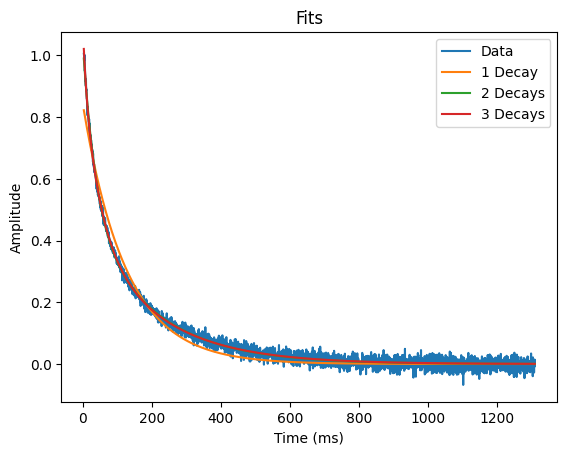

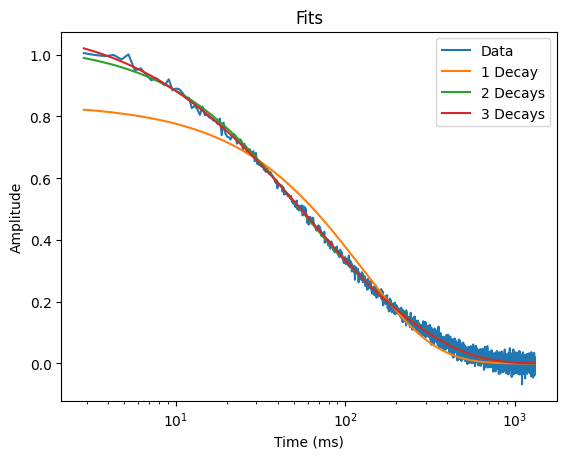

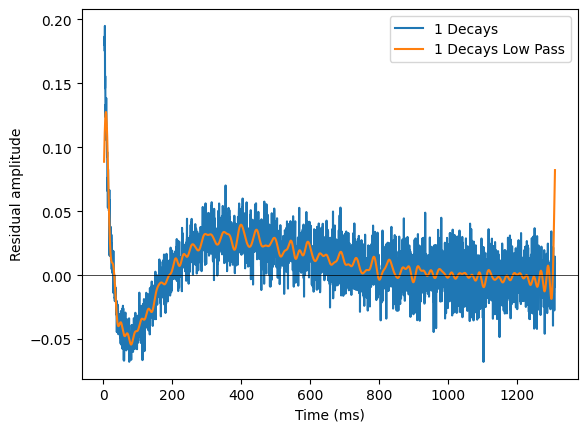

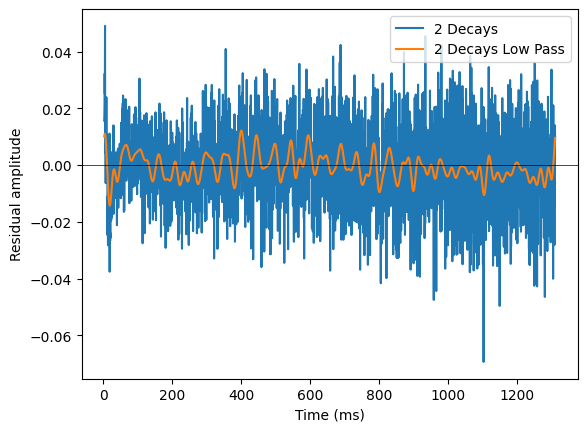

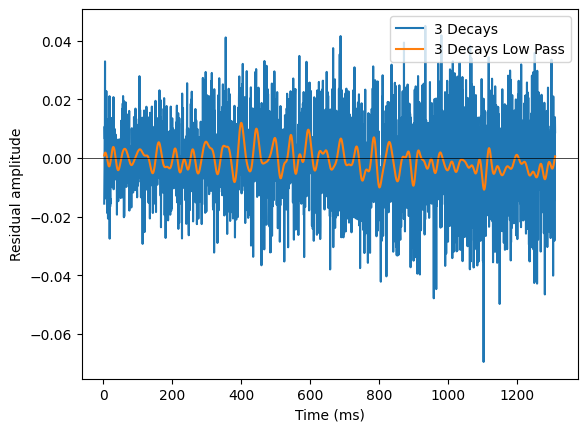

In [104]:

###############################
#### PLOT FITS & RESIDUALS ####
###############################


def low_pass_filter(signal, cutoff_freq, sample_rate):
    # Compute the Fourier transform of the signal
    signal_freq = fft(signal)
    
    # Create the frequency domain
    n = signal_freq.shape[0]
    freqs = jnp.fft.fftfreq(n, d=1/sample_rate)
    
    # Create the filter
    filter = jnp.where(jnp.abs(freqs) < cutoff_freq, 1.0, 0.0)
    
    # Apply the filter
    filtered_signal_freq = signal_freq * filter
    
    # Compute the inverse Fourier transform
    filtered_signal = jnp.real(ifft(filtered_signal_freq))
    
    return filtered_signal

# Plot a comparions of the three
for i in range(2):
    plt.figure()
    plt.plot(time_data, noisy_signal, label="Data")
    plt.plot(time_data, fit_multi_exponential(time_data, *params_1), label="1 Decay")
    plt.plot(time_data, fit_multi_exponential(time_data, *params_2), label="2 Decays")
    plt.plot(time_data, fit_multi_exponential(time_data, *params_3), label="3 Decays")
    plt.xlabel("Time (ms)")
    plt.ylabel("Amplitude")
    plt.title("Fits")
    if i == 1:
        plt.xscale("log")
    plt.legend()
    plt.show()

# Plot the residuals
sample_rate = 1/(time_data[1] - time_data[0])
cutoff_freq = 0.05
for i in range(1, 4):
    
    params = locals()[f"params_{i}"]
    residuals = noisy_signal - fit_multi_exponential(time_data, *params)
    low_pass_residuals = low_pass_filter(residuals, cutoff_freq, sample_rate)
    
    plt.figure()
    plt.plot(time_data, residuals, label=f"{i} Decays")
    plt.plot(time_data, low_pass_residuals, label=f"{i} Decays Low Pass")
    plt.axhline(0, color="black", linewidth=0.5)
    plt.xlabel("Time (ms)")
    plt.ylabel("Residual amplitude")
    plt.legend(loc="upper right")
    plt.show()



2 decays:


c:\Users\omnic\OneDrive\Documents\MIT\Programming\.venv\lib\site-packages\jax\_src\core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(


1000 bootstraps complete in 50.71 seconds.
shape of bootstrap_params before exclusion:  (1000, 4)
shape of bootstrap_params after exclusion:  (1000, 4)


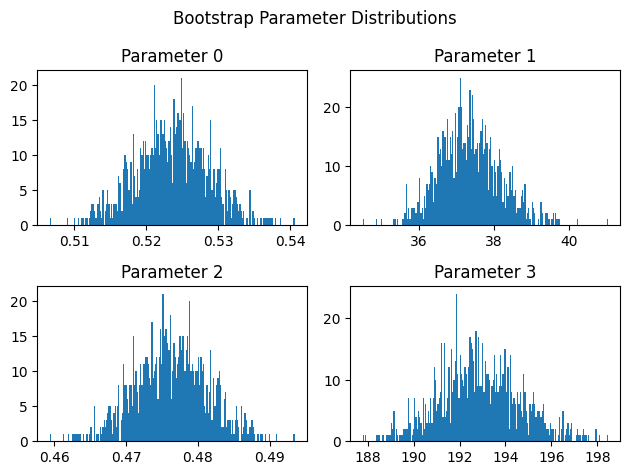

RA1: 	0.513432 to 0.533528
Tau1: 	35.813717 to 39.065903
RA2: 	0.466472 to 0.486568
Tau2: 	189.508698 to 196.647827

3 decays:


c:\Users\omnic\OneDrive\Documents\MIT\Programming\.venv\lib\site-packages\jax\_src\core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(


1000 bootstraps complete in 80.54 seconds.
shape of bootstrap_params before exclusion:  (1000, 6)
shape of bootstrap_params after exclusion:  (1000, 6)


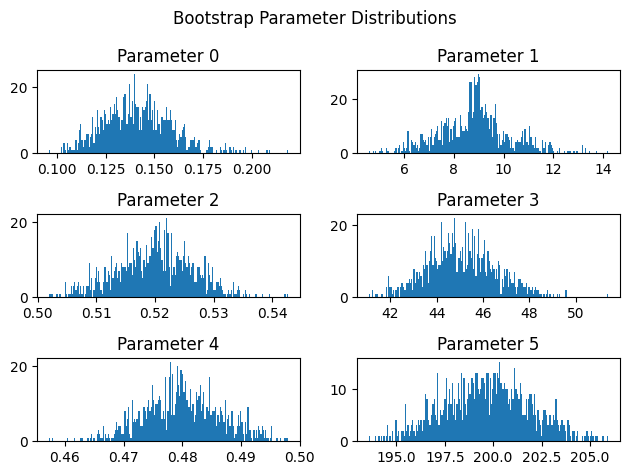

RA0: 	0.111477 to 0.179808
Tau0: 	6.000553 to 11.882293
RA1: 	0.506489 to 0.532959
Tau1: 	42.223423 to 48.164848
RA2: 	0.467041 to 0.493511
Tau2: 	195.453400 to 203.929840


In [105]:

########################################
#### BOOTSTRAP CONFIDENCE INTERVALS ####
########################################

# Define hyperparameters
n_bootstrap = 1000
rng, key = random.split(random.PRNGKey(111), 2)

for dec_index in range(2, 4):
    params = locals()[f"params_{dec_index}"]
    print(f"\n{dec_index} decays:")
    
    # Run the bootstrap
    bootstrap_params = jnp.zeros((n_bootstrap, len(params)))

    # Define the bootstrap solver
    bootstrap_solve = get_bootstrap_solve(
        atol=1e-20,
        time_data=time_data,
        noisy_signal=noisy_signal,
        params=params,
    )

    start = time()
    for i in range(n_bootstrap):
        rng, key = random.split(rng)
        bootstrap_params = bootstrap_params.at[i].set(bootstrap_solve(key)[0])
    print(f"{i+1} bootstraps complete in {time()-start:.2f} seconds.")

    print(f"shape of bootstrap_params before exclusion: ", bootstrap_params.shape)
    # first exclude non-physical parameters
    for i in range(len(params)):
        bootstrap_params = bootstrap_params[bootstrap_params[:, i] > 0]
    for i in range(0, len(params), 2):
        bootstrap_params = bootstrap_params[bootstrap_params[:, i+1] < time_data[-1]]
    print(f"shape of bootstrap_params after exclusion: ", bootstrap_params.shape)
    
    # Perform normalization of amplitudes
    contains_low_tau = jnp.sum(params[1::2] < 20)
    for i in range(n_bootstrap):
        
        amplitudes = bootstrap_params[i, ::2]
        taus = bootstrap_params[i, 1::2]
        amp_sum = jnp.sum(amplitudes[taus > 20])
        bootstrap_params = bootstrap_params.at[i, ::2].set(bootstrap_params[i, ::2] / amp_sum)

    # plot the bootstrap parameters
    fig, ax = plt.subplots(params.shape[0]//2, 2)
    ax = ax.flatten()
    for j in range(params.shape[0]):
        ax[j].hist(bootstrap_params[:, j], bins=200)
        ax[j].set_title(f"Parameter {j}")
    plt.suptitle("Bootstrap Parameter Distributions")
    plt.tight_layout()
    plt.show()

    # now to find the 95% confidence intervals
    contains_low_tau = jnp.sum(params[1::2] < 20)
    for i in range(params.shape[0]):
        lower = jnp.percentile(bootstrap_params[:, i], 2.5)
        upper = jnp.percentile(bootstrap_params[:, i], 97.5)
        
        parameter_name = ("RA" if i%2 == 0 else "Tau") + str(i//2 + 1 - contains_low_tau)
        print(f"{parameter_name}: \t{lower:.6f} to {upper:.6f}")
        
        # add values to the copy dict
        if dec_index == 2 and i%2 == 0 and i//2 + 1 == 2:
            copy_dict["RA2_2_lower"] = lower
            copy_dict["RA2_2_upper"] = upper
        elif dec_index == 3 and i%2 == 0:
            if i//2 + 1 == 2:
                copy_dict["RA2_3_lower"] = lower
                copy_dict["RA2_3_upper"] = upper
            elif i//2 + 1 == 3:
                copy_dict["RA3_3_lower"] = lower
                copy_dict["RA3_3_upper"] = upper
        

shape of bootstrap_params before exclusion:  (1000, 6)
shape of bootstrap_params after exclusion:  (1000, 6)


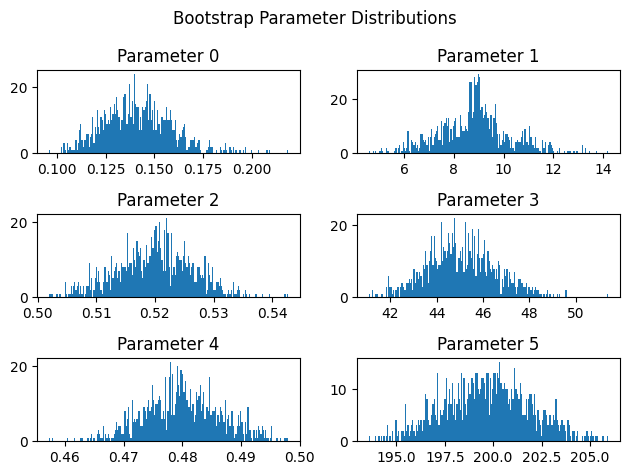

RA1: 	0.111477 to 0.179808
Tau1: 	6.00 to 11.88
RA2: 	0.506489 to 0.532959
Tau2: 	42.22 to 48.16
RA3: 	0.467041 to 0.493511
Tau3: 	195.45 to 203.93


In [106]:
print(f"shape of bootstrap_params before exclusion: ", bootstrap_params.shape)
# first exclude non-physical parameters
for i in range(len(params)):
    bootstrap_params = bootstrap_params[bootstrap_params[:, i] > 0]
for i in range(0, len(params), 2):
    bootstrap_params = bootstrap_params[bootstrap_params[:, i+1] < time_data[-1]]

# exclude all parameters where tau1 > 20
bootstrap_params = bootstrap_params[bootstrap_params[:, 0] < 0.9]
print(f"shape of bootstrap_params after exclusion: ", bootstrap_params.shape)

# plot the bootstrap parameters
fig, ax = plt.subplots(params.shape[0]//2, 2)
ax = ax.flatten()
for j in range(params.shape[0]):
    ax[j].hist(bootstrap_params[:, j], bins=200)
    ax[j].set_title(f"Parameter {j}")
plt.suptitle("Bootstrap Parameter Distributions")
plt.tight_layout()
plt.show()

# now to find the 95% confidence intervals
contains_low_tau = jnp.sum(params[1::2] < 20)
for i in range(params.shape[0]):
    lower = jnp.percentile(bootstrap_params[:, i], 2.5)
    upper = jnp.percentile(bootstrap_params[:, i], 97.5)
    
    parameter_name = ("A" if i%2 == 0 else "Tau") + str(i//2 + 1 - contains_low_tau)
    decay_number = i//2 + 1
    if i%2 == 0:
        print(f"RA{decay_number}: \t{lower:.6f} to {upper:.6f}")
    else:
        print(f"Tau{decay_number}: \t{lower:.2f} to {upper:.2f}")




Wihtout offset adjustment
A1: 	0.5581 to 0.5875
Tau1: 	50.4689 to 53.6543
A2: 	0.4371 to 0.4695
Tau2: 	179.7641 to 186.9140

With offset adjustment
A1: 	0.3234 to 0.8284
Tau1: 	22.2091 to 80.0286
A2: 	0.1720 to 0.7344
Tau2: 	131.9008 to 396.9913

In [107]:
# Now to format the copy_dict into a string that can be copied and pasted into google sheets

# The order of the string is important, so we will define the order here
string_order = [
    "Name",
    
    "SNR_2", "Tau1_2", "Tau2_2", "RA2_2", 
    "RA2_2_lower", "RA2_2_upper", 
    "swp_2", "dw_2",
    
    "SNR_3", "Tau1_3", "Tau2_3", "Tau3_3", "RA1_3", "RA2_3", "RA3_3",
    "RA2_3_lower", "RA2_3_upper", "RA3_3_lower", "RA3_3_upper",
    "swp_3", "dw_3",
]

# taus will be to 2 decimal places
# RA values and their lower and upper confidence intervals will be to 6 decimal places
# swp and dw will be to 5 decimal places
# snr will be to 2 decimal place

from jaxlib.xla_extension import ArrayImpl

copy_string = ""

for key in string_order:
    if key in copy_dict:
        if type(copy_dict[key]) == ArrayImpl:
            # print("We got one!!!!")
            # copy_dict[key] = copy_dict[key].astype(copy_dict[key].dtype)
            copy_dict[key] = copy_dict[key].tolist()

print(copy_dict)

# now to format the string
for key in string_order:
    if key not in copy_dict:
        copy_string += ", "
        print(f"WARNING: {key} not found in copy_dict")
        continue
    # get the value
    value = copy_dict[key]
    
    if type(value) == str:
        copy_string += value + ", "
    elif type(value) in [float, jnp.float32, jnp.float64]:
        
        # format the value based on the specification above
        if "RA" in key:
            copy_string += f"{value:.6f}, "
        elif "Tau" in key:
            copy_string += f"{value:.2f}, "
        elif "swp" in key or "dw" in key:
            copy_string += f"{value:.5f}, "
        elif "SNR" in key:
            copy_string += f"{value:.2f}, "
    else:
        raise ValueError("Invalid type for value: " + str(type(value)))

# remove the last comma and space becasue we're civilized
copy_string = copy_string[:-2]

# print the string and make sure not to copy the name
print(copy_string)
print(f"\nsignal length: {len(noisy_signal)}")

raise ValueError("End of script")

{'Name': 'HC12MGHRA-', 'SNR_2': 72.8287353515625, 'Tau1_2': 37.28041458129883, 'Tau2_2': 192.79901123046875, 'RA2_2': 0.4763348400592804, 'swp_2': 0.011838806972131952, 'dw_2': 0.08149027824401855, 'SNR_3': 77.73530578613281, 'Tau1_3': 8.915552139282227, 'Tau2_3': 45.065032958984375, 'Tau3_3': 199.63558959960938, 'RA1_3': 0.1379886120557785, 'RA2_3': 0.5198668241500854, 'RA3_3': 0.48013317584991455, 'swp_3': 0.00165863277688075, 'dw_3': 0.10345041751861572, 'RA2_2_lower': 0.4664723873138428, 'RA2_2_upper': 0.486567884683609, 'RA2_3_lower': 0.5064894556999207, 'RA2_3_upper': 0.5329592823982239, 'RA3_3_lower': 0.4670408070087433, 'RA3_3_upper': 0.49351051449775696}
HC12MGHRA-, 72.83, 37.28, 192.80, 0.476335, 0.466472, 0.486568, 0.01184, 0.08149, 77.74, 8.92, 45.07, 199.64, 0.137989, 0.519867, 0.480133, 0.506489, 0.532959, 0.467041, 0.493511, 0.00166, 0.10345

signal length: 2725


ValueError: End of script

True sigma: 2
Fitted sigma: [1.99312404]


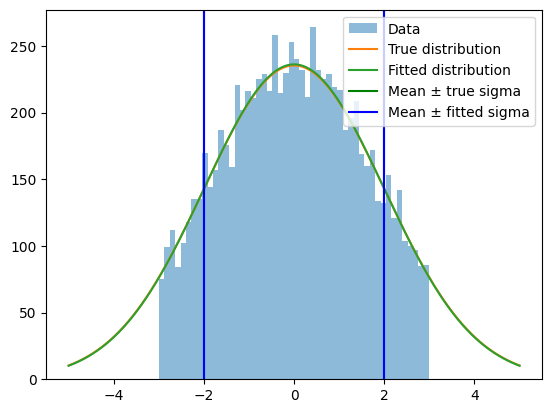

In [ ]:


import numpy as np
from scipy.optimize import minimize
from matplotlib import pyplot as plt
from scipy.stats import norm

# Generate synthetic data: absolute values of a normal distribution
np.random.seed(42)
mu = 0  # Mean of the Gaussian
sigma = 2  # Standard deviation of the Gaussian
data = np.random.normal(mu, sigma, size=10000)
lim = 3
data = data[(data > -lim) & (data < lim)]  # Truncate the data

# Log-likelihood function for truncated normal
def truncated_log_likelihood(params, mu, data, lower, upper):
    sigma = params
    n = len(data)
    # PDF values for the data
    log_pdf = np.sum(norm.logpdf(data, loc=mu, scale=sigma))
    # Log normalization factor
    log_cdf_diff = np.log(norm.cdf(upper, loc=mu, scale=sigma) - norm.cdf(lower, loc=mu, scale=sigma))
    return -(log_pdf - n * log_cdf_diff)  # Negative log-likelihood for minimization

# Initial guess and optimization
initial_guess = [1.0]  # Initial guess for mu and sigma
bounds = [(-lim, lim)]  # Bound sigma
result = minimize(truncated_log_likelihood, initial_guess, args=(mu, data, -lim, lim), bounds=bounds)
fitted_sigma = result.x

print(f"True sigma: {sigma}")
print(f"Fitted sigma: {fitted_sigma}")

# plot the data
scale = 1180
plt.hist(data, bins=50, alpha=0.5, label="Data")
plt.plot(np.linspace(-5, 5, 500), norm.pdf(np.linspace(-5, 5, 500), mu, sigma) * scale, label="True distribution")
plt.plot(np.linspace(-5, 5, 500), norm.pdf(np.linspace(-5, 5, 500), mu, fitted_sigma) * scale, label="Fitted distribution")
plt.axvline(mu + sigma, color="green", label="Mean ± true sigma")
plt.axvline(mu - sigma, color="green")
plt.axvline(mu + fitted_sigma, color="blue", label="Mean ± fitted sigma")
plt.axvline(mu - fitted_sigma, color="blue")
plt.legend()
plt.show()


initial gradient: [2.7747592e-06]
initial second derivative: [-2.077577e-07]
sigma at 1: [27.979828]
	grad: 2.77e-06, hess: -2.08e-07
sigma at 2: [19.555424]
	grad: 8.08e-06, hess: -8.63e-07
sigma at 3: [13.640867]
	grad: 2.35e-05, hess: -3.58e-06
sigma at 4: [9.47695]
	grad: 6.84e-05, hess: -1.48e-05
sigma at 5: [6.525708]
	grad: 1.98e-04, hess: -6.05e-05
sigma at 6: [4.393399]
	grad: 5.71e-04, hess: -2.41e-04
sigma at 7: [2.726799]
	grad: 1.59e-03, hess: -8.61e-04
sigma at 8: [-551.878]
	grad: 3.42e-03, hess: -5.55e-06
sigma at 9: [nan]
	grad: nan, hess: nan
sigma at 10: [nan]
	grad: nan, hess: nan
sigma at 11: [nan]
	grad: nan, hess: nan
sigma at 12: [nan]
	grad: nan, hess: nan
sigma at 13: [nan]
	grad: nan, hess: nan
sigma at 14: [nan]
	grad: nan, hess: nan
sigma at 15: [nan]
	grad: nan, hess: nan
sigma at 16: [nan]
	grad: nan, hess: nan
sigma at 17: [nan]
	grad: nan, hess: nan
sigma at 18: [nan]
	grad: nan, hess: nan
sigma at 19: [nan]
	grad: nan, hess: nan
sigma at 20: [nan]
	gra

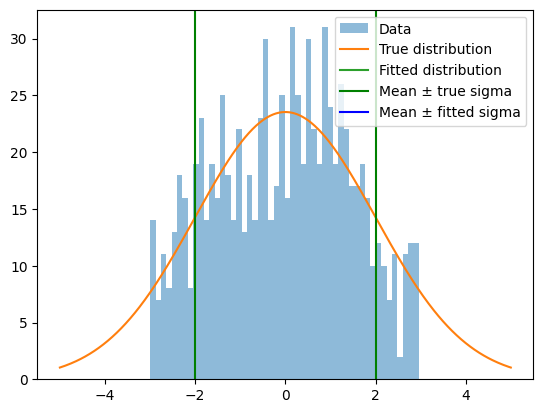

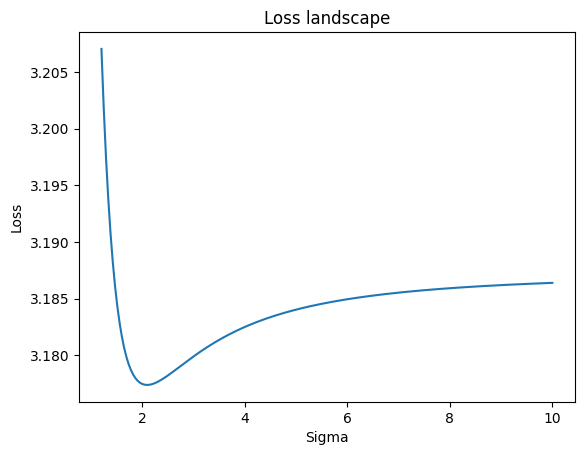

In [ ]:
import jax
import jax.numpy as jnp
from jax.scipy.stats import norm
from matplotlib import pyplot as plt
from jaxopt import BFGS

# Generate synthetic data: absolute values of a normal distribution
key = jax.random.PRNGKey(42)
mu = 0  # Mean of the Gaussian
sigma = 2  # Standard deviation of the Gaussian
data = jax.random.normal(key, shape=(1000,)) * sigma + mu
lim = 3
data = data[(data > -lim) & (data < lim)]  # Truncate the data

# Log-likelihood function for truncated normal
@jax.jit
def truncated_log_likelihood(params, mu, data, lower, upper):
    sigma = params[0]  # Unpack parameters
    n = data.size
    # PDF values for the data
    log_pdf = jnp.sum(norm.logpdf(data, loc=mu, scale=sigma))
    # Log normalization factor
    log_cdf_diff = jnp.log(norm.cdf(upper, loc=mu, scale=sigma) - norm.cdf(lower, loc=mu, scale=sigma))
    return jnp.log10(-(log_pdf - n * log_cdf_diff))  # Negative log-likelihood for minimization

# Initial guess and optimization
initial_guess = jnp.array([40.0])  # Initial guess for sigma

likelihood_grad = jax.jit(jax.grad(lambda params: truncated_log_likelihood(params, mu, data, -lim, lim)))
likelihood_hess = jax.jit(jax.grad(lambda params: likelihood_grad(params)[0]))

print(f"initial gradient: {likelihood_grad(initial_guess)}")
print(f"initial second derivative: {likelihood_hess(initial_guess)}")

fitted_sigma = initial_guess

grad_tol = 1e-10

damping = 0.9

for i in range(20):
    grad_i = likelihood_grad(fitted_sigma)
    hess_i = likelihood_hess(fitted_sigma)
    fitted_sigma = fitted_sigma - grad_i/jnp.abs(hess_i)*damping
    print(f"sigma at {i+1}: {fitted_sigma}")
    print(f"\tgrad: {grad_i.tolist()[0]:.2e}, hess: {hess_i.tolist()[0]:.2e}")

# fitted_sigma, state = solver.run(initial_guess)

print(f"state: {state}")

print(f"True sigma: {sigma}")
print(f"Fitted sigma: {fitted_sigma}")

# plot the data
scale = 118
x = jnp.linspace(-5, 5, 500)
plt.hist(data, bins=50, alpha=0.5, label="Data")
plt.plot(x, norm.pdf(x, loc=mu, scale=sigma) * scale, label="True distribution")
plt.plot(x, norm.pdf(x, loc=mu, scale=fitted_sigma[0]) * scale, label="Fitted distribution")
plt.axvline(mu + sigma, color="green", label="Mean ± true sigma")
plt.axvline(mu - sigma, color="green")
plt.axvline(mu + fitted_sigma[0], color="blue", label="Mean ± fitted sigma")
plt.axvline(mu - fitted_sigma[0], color="blue")
plt.legend()
plt.show()

# plot the loss landscape
sigma_values = jnp.linspace(1.2, 10, 200)
loss_values = jnp.array([truncated_log_likelihood(jnp.array([sigma]), mu, data, -lim, lim) for sigma in sigma_values])

plt.plot(sigma_values, loss_values)
# plt.xscale("log")
# plt.yscale("log")
plt.xlabel("Sigma")
plt.ylabel("Loss")
plt.title("Loss landscape")
plt.show()

In [ ]:
import jax
import jax.numpy as jnp
from jax.scipy.stats import norm
from functools import partial

# custom_power = lambda x: jax.lax.pow(1.001, x)
# custom_log = lambda x: jax.lax.log(x) / jax.lax.log(1.001)

def optimize_truncated_log_likelihood(data, mu, lower, upper, initial_guess, damping=0.9, maxiter=20, grad_tol=None):
    
    # Center the data and limits around zero
    data = data - mu
    lower = lower - mu
    upper = upper - mu
    
    #@jax.jit
    def truncated_log_likelihood(params):
        sigma = params[0]  # Unpack and exponentiate parameters to ensure positivity
        n = data.size
        # PDF values for the data
        log_pdf = jnp.sum(norm.logpdf(data, loc=0, scale=sigma))
        # Log normalization factor
        log_cdf_diff = jnp.log(norm.cdf(upper, loc=0, scale=sigma) - norm.cdf(lower, loc=0, scale=sigma))
        return jnp.log10(-(log_pdf - n * log_cdf_diff))  # Negative log-likelihood for minimization

    # Gradient and Hessian functions
    likelihood_grad = jax.jit(jax.grad(lambda params: truncated_log_likelihood(params)))
    likelihood_hess = jax.jit(jax.grad(lambda params: likelihood_grad(params)[0]))

    fitted_sigma = initial_guess  # Use log of initial guess
    
    prev = initial_guess

    for i in range(maxiter):
        
        # if jnp.abs(fitted_sigma) > custom_log(initial_guess):
        #     damping *= 0.5
        #     fitted_sigma = prev
        
        grad_i = likelihood_grad(fitted_sigma)
        hess_i = likelihood_hess(fitted_sigma)
        step = grad_i / jnp.abs(hess_i) * damping
        
        print(f"at step {i+1}, the value is {fitted_sigma} and the adjustement is {step/damping}")
        fitted_sigma = fitted_sigma - step
        print(f"so the next step will be at {fitted_sigma}")

        # print(f"sigma at {i+1}: {custom_power(fitted_sigma)}")  # Exponentiate to get the actual sigma value
        # print(f"\tgrad: {grad_i.tolist()[0]:.2e}, hess: {hess_i.tolist()[0]:.2e}")

        if grad_tol is not None and jnp.abs(grad_i) < grad_tol:
            print("Gradient tolerance reached. Optimization terminated early.")
            break
        if jnp.isclose(fitted_sigma, prev, atol=1e-10):
            print("Convergence reached. Optimization terminated early.")
            break
        prev = fitted_sigma
            

    return fitted_sigma  # Return the exponentiated value

# Example usage
key = jax.random.PRNGKey(43)
mu = 0  # Mean of the Gaussian
sigma = 2  # Standard deviation of the Gaussian
data = jax.random.normal(key, shape=(1000,)) * sigma + mu
lim = 3
data = data[(data > -lim) & (data < lim)]  # Truncate the data

initial_guess = jnp.array([40.0])  # Initial guess for sigma
fitted_sigma = optimize_truncated_log_likelihood(data, mu, -lim, lim, initial_guess, damping=1.0, maxiter=200, grad_tol=1e-10)

print(f"Optimized sigma: {fitted_sigma}")



at step 1, the value is [40.] and the adjustement is [13.3550625]
so the next step will be at [26.644938]
at step 2, the value is [26.644938] and the adjustement is [8.913064]
so the next step will be at [17.731873]
at step 3, the value is [17.731873] and the adjustement is [5.961382]
so the next step will be at [11.770491]
at step 4, the value is [11.770491] and the adjustement is [4.003063]
so the next step will be at [7.7674274]
at step 5, the value is [7.7674274] and the adjustement is [2.7178793]
so the next step will be at [5.049548]
at step 6, the value is [5.049548] and the adjustement is [1.9198093]
so the next step will be at [3.1297388]
at step 7, the value is [3.1297388] and the adjustement is [1.8577427]
so the next step will be at [1.2719961]
at step 8, the value is [1.2719961] and the adjustement is [-0.23418856]
so the next step will be at [1.5061847]
at step 9, the value is [1.5061847] and the adjustement is [-0.2029316]
so the next step will be at [1.7091163]
at step 

In [ ]:
print(0.00558983 - (-8.69e-01)/(1.62e-04))

print(jnp.log(15)/jnp.log(10))
print(jnp.log10(15))

from functools import partial
import jax
from jax import numpy as jnp

# custom_power = partial(lambda x: jnp.power(1.1, x), jax.lax.Precision.HIGHEST)
# custom_log = partial(lambda x: jnp.log(x)/jnp.log(1.1), jax.lax.Precision.HIGHEST)

x = jax.lax.pow(1.01, 1050.0)   
print(x)
x = jax.lax.log(x)/jax.lax.log(1.01)
print(x)

# x = 15 

# print(custom_log(15))
# print(custom_power(15))

# print(custom_power(custom_log(x)))
# print(custom_log(custom_power(x)))

# jnp.log(1.01**15)/jnp.log(1.01)

# plot the loss landscape
sigma_values = jnp.linspace(1.2, 10, 200)
loss_values = jnp.array([truncated_log_likelihood(sigma, data, -lim, lim) for sigma in sigma_values])

plt.plot(sigma_values, loss_values)
# plt.xscale("log")
# plt.yscale("log")
plt.xlabel("Sigma")
plt.ylabel("Loss")
plt.title("Loss landscape")
plt.show()

5364.203120694197
1.1760913
1.1760912
34469.754
1050.0


TypeError: truncated_log_likelihood() missing 1 required positional argument: 'upper'

2730
Initial params: [  0.4  40.    0.6 220. ]
Initial loss: 0.5358131898302418
gradient: [ 4.09214379e-02  7.63466252e-04  8.34790753e-02 -1.84475504e-05]
change: [ 0.00205793  0.95966066 -0.00409847  0.85559285]
i: 0	 loss: 0.5358131898302418
[  0.39794207  39.04033934   0.60409847 219.14440715]
gradient: [-1.21834073e-03 -2.90257832e-05 -2.92791820e-03  4.89522375e-07]
change: [-6.64898416e-05 -3.50502942e-02  1.47153666e-04 -3.07530789e-02]
i: 1	 loss: 0.5355896692032296
[  0.39800856  39.07538964   0.60395132 219.17516023]
gradient: [-1.88821671e-06 -4.07642293e-08 -4.46501205e-06  3.72891761e-10]
change: [-9.12541185e-08 -4.74268293e-05  1.97860040e-07 -4.12923709e-05]
i: 2	 loss: 0.5355893426772581
[  0.39800866  39.07543706   0.60395112 219.17520152]
gradient: [-3.19589377e-12 -7.45359859e-14 -7.84143583e-12  9.51875297e-16]
change: [-1.62889354e-13 -8.80442266e-11  3.65600675e-13 -7.60911994e-11]
i: 3	 loss: 0.5355893426766547
[  0.39800866  39.07543706   0.60395112 219.175201

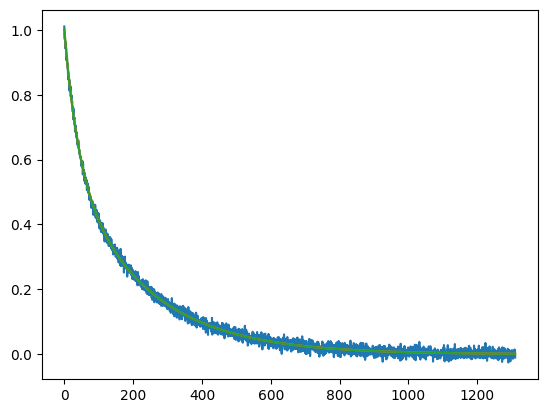

In [ ]:
from jax import grad, value_and_grad, hessian, config
config.update("jax_enable_x64", True)
from jax.lax import Precision
from functools import partial

_dot = partial(jnp.dot, precision=Precision.HIGHEST)

dt = 0.48
t_count = 2730
t = jnp.linspace(0, dt*t_count, t_count, endpoint=False)

decay_constants = jnp.array([
    0.4, 40.0,
    0.6, 220.0,
])

clean_signal = exponential(t, decay_constants[0], decay_constants[1]) + exponential(t, decay_constants[2], decay_constants[3])

print(clean_signal.shape[0])

rng, key = random.split(random.PRNGKey(42))

SNR = 100
noise_sd = jnp.sum(decay_constants[::2])/SNR
noisy_signal = clean_signal + random.normal(key, clean_signal.shape)*noise_sd

def newton_fit(t, decay, initial_params, maxiter=100):
    
    def rmse_loss(params):
        fit = exponential(t, params[0], params[1]) + exponential(t, params[2], params[3])
        return jnp.sqrt(jnp.sum(jnp.square(decay-fit)))
    
    loss_grad = grad(rmse_loss)
    loss_hess = hessian(rmse_loss)
    
    def newton_step(params):
        
        _loss = rmse_loss(params)
        _loss_grad = loss_grad(params)
        _loss_hess_inv = jnp.linalg.inv(loss_hess(params))
        
        print(f"gradient: {_loss_grad}")
        print(f"change: {_dot(_loss_hess_inv, _loss_grad)}")
        
        return params - _dot(_loss_hess_inv, _loss_grad), _loss

    params = initial_params
    print(f"Initial params: {params}")
    print(f"Initial loss: {rmse_loss(params)}")
    
    for i in range(maxiter):
        params, loss = newton_step(params)
        print(f"i: {i}\t loss: {loss}")
        print(params)
    
    return params
        
fit_params = newton_fit(t, decay=noisy_signal, initial_params=decay_constants, maxiter=10)
fit_signal = exponential(t, fit_params[0], fit_params[1]) + exponential(t, fit_params[2], fit_params[3])

print_params(fit_params)

print(f"params dtype: {fit_params.dtype}")

plt.plot(t, noisy_signal, label="Noisy")
plt.plot(t, clean_signal, label="Clean")
plt.plot(t, fit_signal, label="Fit")
plt.show()


In [ ]:
A = jnp.array([[1., 2., 3.],
               [2., 4., 2.],
               [3., 2., 1.]])
x = jnp.linalg.solve(A, jnp.eye(3))

print(x)

print(A @ x)

b = jnp.linalg.inv(A)
print(b)
print(b @ A)

[[ 0.         -0.25        0.5       ]
 [-0.25        0.5        -0.25000003]
 [ 0.5        -0.25        0.        ]]
[[ 1.0000000e+00  0.0000000e+00 -5.9604645e-08]
 [ 0.0000000e+00  1.0000000e+00 -1.1920929e-07]
 [ 0.0000000e+00  0.0000000e+00  9.9999994e-01]]
[[ 0.         -0.25        0.5       ]
 [-0.25        0.5        -0.25000003]
 [ 0.5        -0.25        0.        ]]
[[ 1.0000000e+00  0.0000000e+00  0.0000000e+00]
 [-8.9406967e-08  9.9999994e-01 -2.9802322e-08]
 [ 0.0000000e+00  0.0000000e+00  1.0000000e+00]]
